# Evaluation of a Tree Clustering Algorithm

Given samples $\{\mathbf x_i, y_i \}$, we classify the samples in an *unsupervised* manner using a decision-tree-like algorithm, meaning that the ground truth labels $y_i$ are invisible to the algorithm. We then evaluate the trees by computing the loss-depth curve, which shows at given depth of the tree, how well is the clustering performance.

For example, we can use the impurity as the loss function. Suppose at depth $d$, the tree consists of $m_d$ nodes, each of which contains reigon $\{ R^d_i \}_{i=1}^{m_d}$. Suppose there are $c$ ground truth classes (number of geometries in the scene). The loss the tree at depth $d$ is defined as

$$

L(d) = \sum_{i=1}^{m_d} \mathbb P(\mathbf x \in R^d_i) \cdot \mathrm{Imp}(R^d_i) \\

\mathrm{Imp}(R) = \sum_{j=1}^c - \mathbb P(y = j | \mathbf x \in R) \log \mathbb P(y = j | \mathbf x \in R)

$$

Suppose the count of each class in region $R$ is $\{ n_j \}_{j=1}^c$, then

$$

\mathrm{Imp}(R) = \sum_{j=1}^c - \frac{n_j}{\sum_{k=1}^c n_k} \log \frac{n_j}{\sum_{k=1}^c n_k}

$$

In [1]:
import numpy as np
from scipy.special import xlogy
import matplotlib.pyplot as plt
import csv

In [2]:
root_dir = "/local/home/zhengfe/Thesis/PBRT-v4/results/vs"
scene, variant = "cbox-classic", ""
method = "vsig"
iteration = 1

kdtree_path = f"{root_dir}/{scene}/{scene}{variant}-kdtree_{method}-dump.csv"
sample_dir = f"{root_dir}/{scene}/{scene}{variant}-samples-{method}-dump"
position_path = f"{sample_dir}/position-{iteration}.npy"
shapeId_path = f"{sample_dir}/shapeId-{iteration}.npy"

# Load samples
samples = np.load(position_path)
ids = np.load(shapeId_path)
_, ids = np.unique(ids, return_inverse=True)  # Reindex ids
assert len(samples) == len(ids)
print(f"Loaded {len(samples)} samples")

Loaded 57327 samples


In [10]:
# KD Tree data structure
def gini(p):
    return 1 - np.sum(p ** 2)

def entropy(p):
    return -np.sum(xlogy(p, p)) / np.log(2)

class Node:
    def __init__(self):
        self.depth = None
        self.lower, self.upper = None, None
        self.split_dim, self.split_pos = None, None
        self.left, self.right = None, None
        self.num_samples_cache, self.loss_cache = None, None
    
    def is_leaf(self):
        return self.split_dim is None
    
    def is_internal(self):
        return not self.is_leaf()
    
    def set_bounds(self, lower, upper):
        self.lower, self.upper = lower, upper
    
    def set_leaf(self):
        self.split_dim, self.split_pos = None, None
        self.left, self.right = None, None

    def set_internal(self, split_dim, split_pos, left, right):
        self.split_dim, self.split_pos = split_dim, split_pos
        self.left, self.right = left, right
    
    def compute_loss(self, metric, samples, ids):
        # assert (self.lower <= samples).all() and (samples <= self.upper).all()
        # assert len(samples) == len(ids)
        if len(ids) == 0: return 0
        _, counts = np.unique(ids, return_counts=True)
        p = counts / len(ids)
        return metric(p)
    
    def validate(self, depth):
        if self.depth != depth: return False
        if self.is_leaf():
            return self.left is None and self.right is None
        else:
            if self.split_dim not in [0, 1, 2]: return False
            if not isinstance(self.split_pos, float): return False
            if not isinstance(self.left, Node) or not isinstance(self.right, Node): return False
            return self.left.validate(depth + 1) and self.right.validate(depth + 1)
    
    def height(self):
        if self.is_leaf():
            return 1
        else:
            return 1 + max(self.left.height(), self.right.height())

    def update_loss(self, metric, samples, ids):
        self.num_samples_cache = len(samples)
        self.loss_cache = self.compute_loss(metric, samples, ids)
        if self.is_internal():
            left_mask = samples[:, self.split_dim] < self.split_pos
            left_samples, left_ids = samples[left_mask], ids[left_mask]
            right_samples, right_ids = samples[~left_mask], ids[~left_mask]
            self.left.update_loss(metric, left_samples, left_ids)
            self.right.update_loss(metric, right_samples, right_ids)
    
    def __repr__(self):
        if self.is_leaf():
            return f"Leaf({self.lower} - {self.upper}, samples: {self.num_samples_cache}, loss: {self.loss_cache})"
        else:
            return f"Internal({self.lower} - {self.upper}, dim: {self.split_dim}, pivot: {self.split_pos}, samples: {self.num_samples_cache}, loss: {self.loss_cache})"


def load_tree(csv_path) -> Node:
    content = []
    with open(csv_path, "r") as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if i == 0:
                assert row == ['depth', 'node_idx', 'lower_x', 'lower_y', 'lower_z', 'upper_x', 'upper_y', 'upper_z', 'split_dim', 'split_pos', 'left_child_idx']
                continue
            content.append(row)

    num_nodes = len(content)
    nodes = [None] * num_nodes

    for row in content:
        depth, node_idx, lower_x, lower_y, lower_z, upper_x, upper_y, upper_z, split_dim, split_pos, left_child_idx = row
        depth, node_idx = int(depth), int(node_idx)
        assert nodes[node_idx] is None, f"Node {node_idx} already exists"
        node = nodes[node_idx] = Node()
        node.depth = depth
        lower = np.array([float(lower_x), float(lower_y), float(lower_z)])
        upper = np.array([float(upper_x), float(upper_y), float(upper_z)])
        node.set_bounds(lower, upper)
        split_pos = float(split_pos)
        if np.isnan(split_pos):
            # Leaf node
            node.set_leaf()
        else:
            # Internal node
            split_dim, left_child_idx = int(split_dim), int(left_child_idx)
            right_child_idx = left_child_idx + 1
            node.set_internal(split_dim, split_pos, left_child_idx, right_child_idx)
    
    assert all(node is not None for node in nodes), "Some nodes are missing"
    for node in nodes:  # Resolve child pointers
        if node.is_internal():
            left, right = node.left, node.right
            node.left, node.right = nodes[left], nodes[right]
    root: Node = nodes[0]
    assert root.validate(1), "Tree is invalid"
    return root

tree = load_tree(kdtree_path)
print(tree)
print(f"Height: {tree.height()}")

Internal([-3.     -2.     -2.9997] - [3.     4.     2.9994], dim: 0, pivot: 0.996302, samples: None, loss: None)
Height: 14


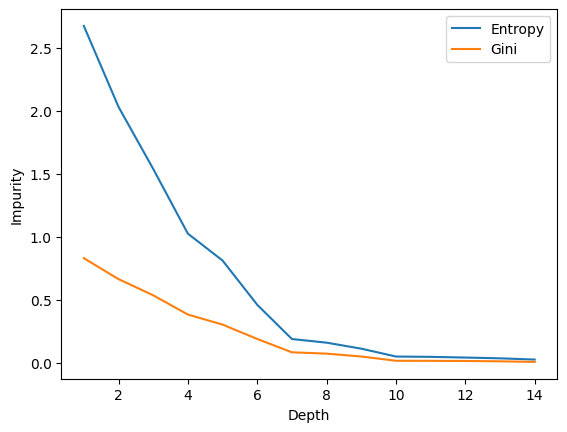

In [4]:
# Compute the loss curve while sweeping the depth
def compute_impurity_curve(tree: Node, metric, samples, ids):
    tree.update_loss(metric, samples, ids)
    depths = []
    losses = []
    nodes = [tree]
    curr_depth = 1
    while True:
        # print(f"Depth {curr_depth}, nodes: {len(nodes)}")
        num_samples = np.array([node.num_samples_cache for node in nodes])
        impurities = np.array([node.loss_cache for node in nodes])
        loss = np.average(impurities, weights=num_samples)
        depths.append(curr_depth)
        losses.append(loss)

        new_nodes = []
        expanded = False
        for node in nodes:
            if node.is_internal():
                expanded = True
                new_nodes += [node.left, node.right]
            else:
                new_nodes.append(node)
        if not expanded:
            break
        nodes = new_nodes  # Expand nodes until all are leaves
        curr_depth += 1
    assert curr_depth == tree.height()
    return depths, losses

depths, entropies = compute_impurity_curve(tree, entropy, samples, ids)
depths, ginis = compute_impurity_curve(tree, gini, samples, ids)

# Plot the impurity curve
plt.figure()
plt.plot(depths, entropies, label="Entropy")
plt.plot(depths, ginis, label="Gini")
plt.xlabel("Depth")
plt.ylabel("Impurity")
plt.legend()
plt.show()

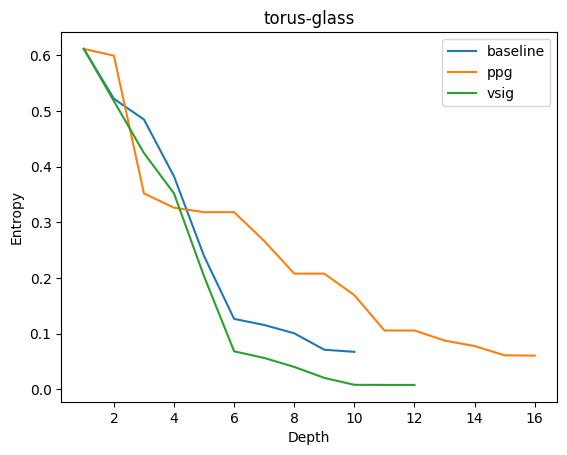

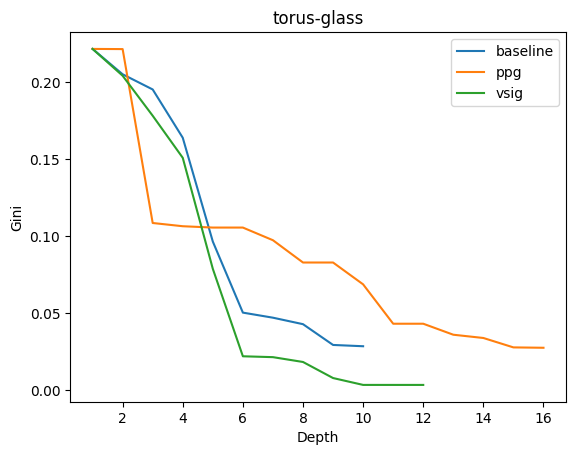

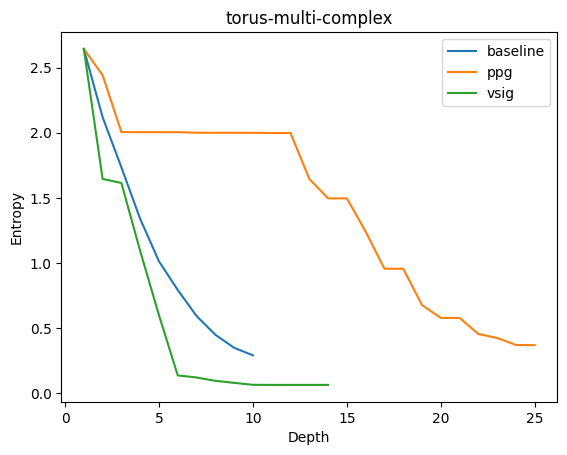

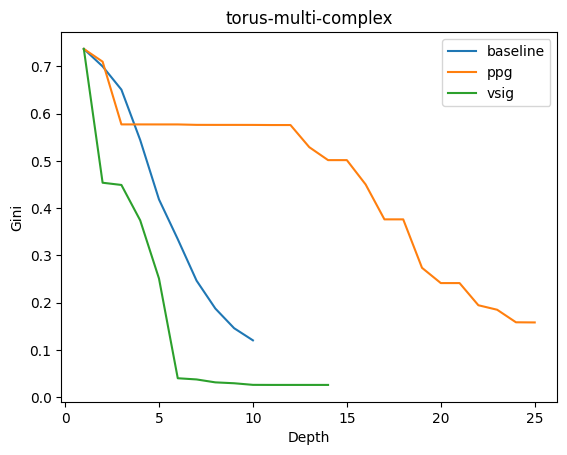

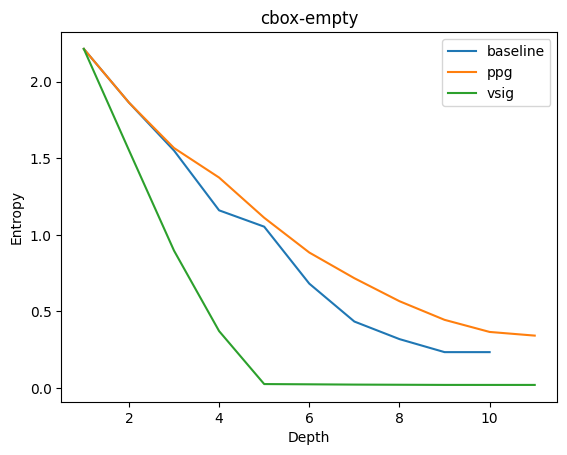

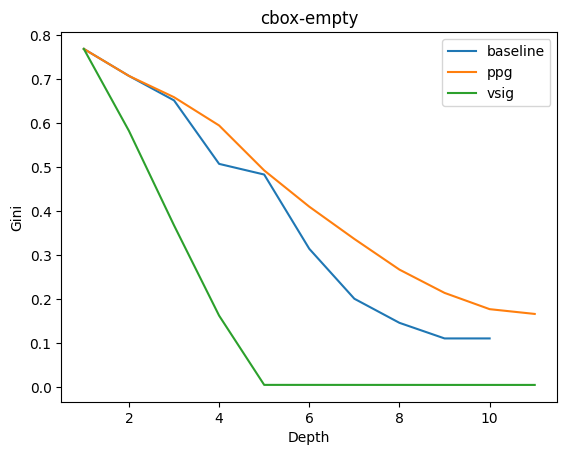

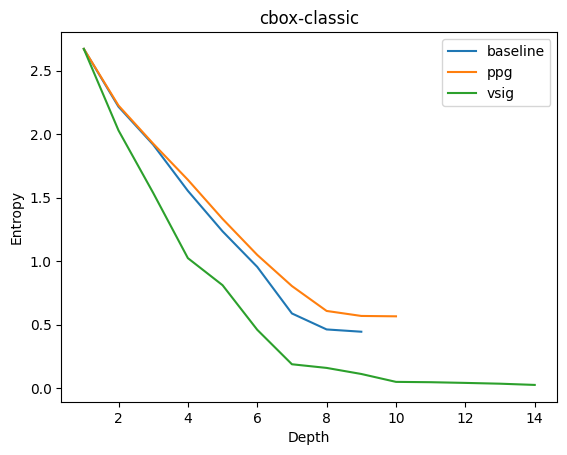

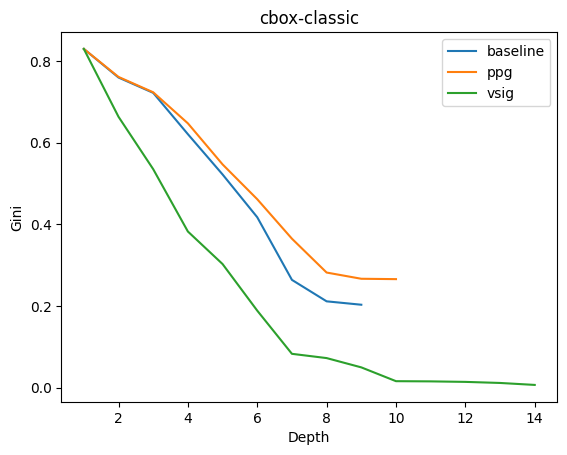

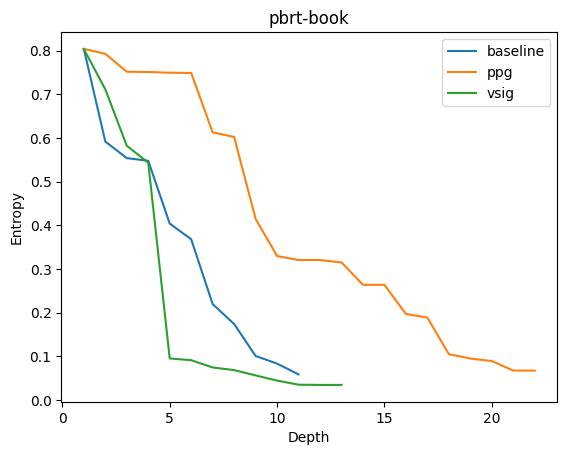

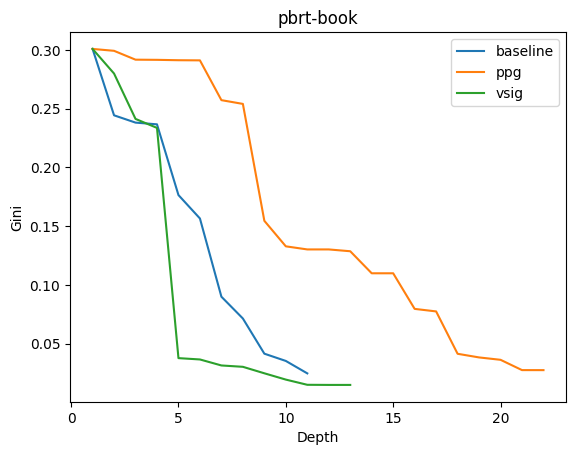

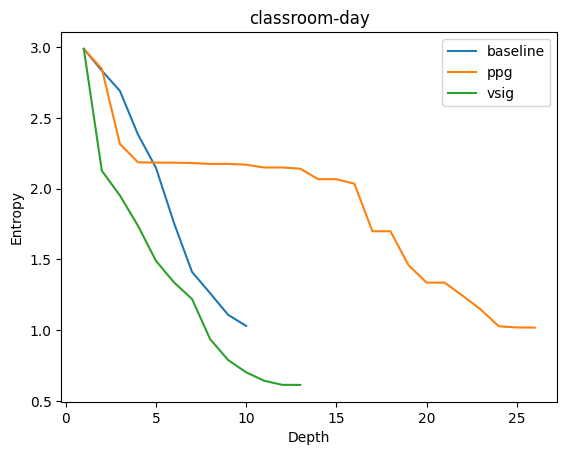

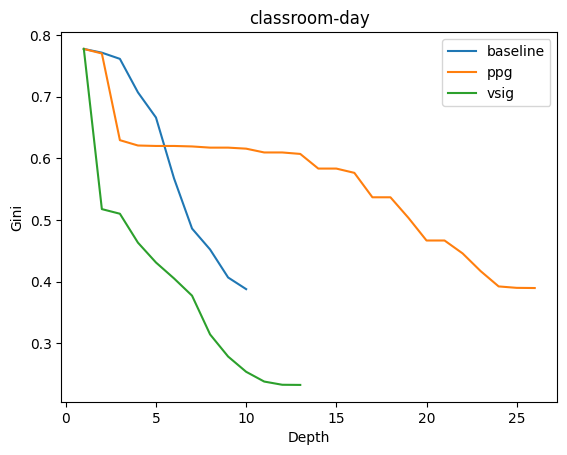

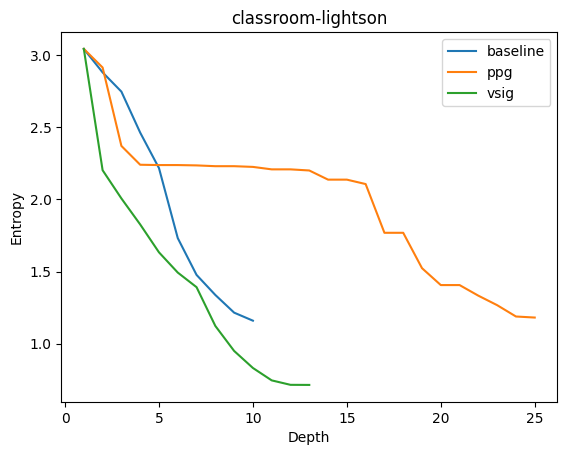

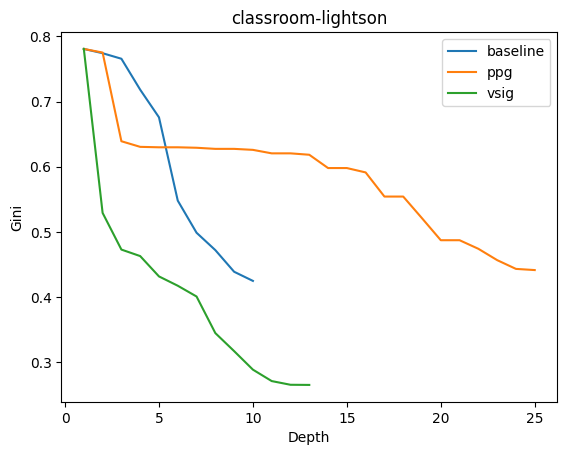

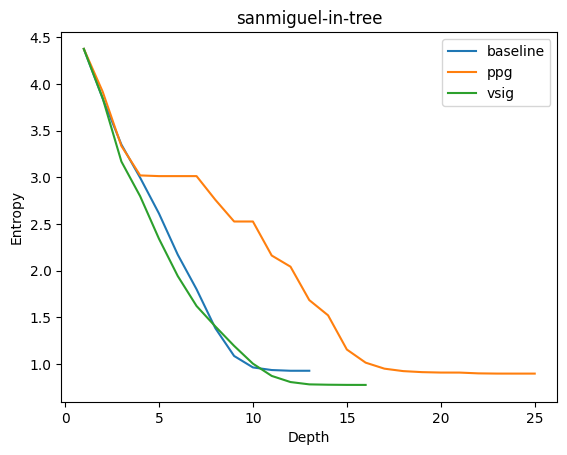

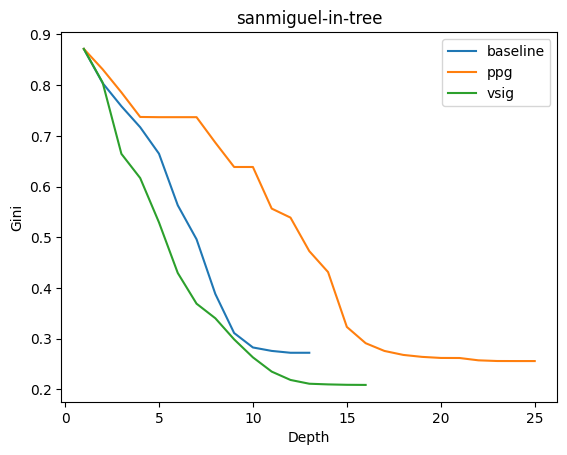

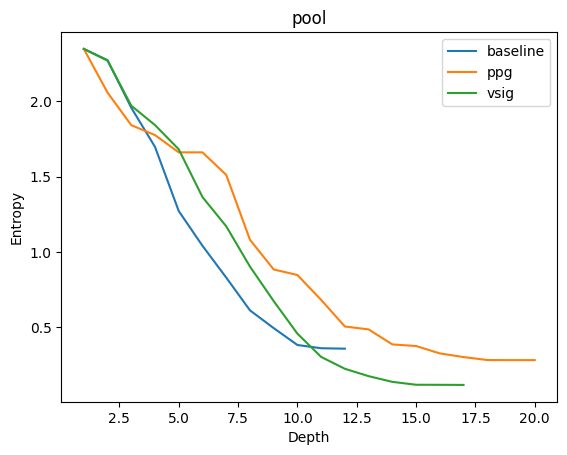

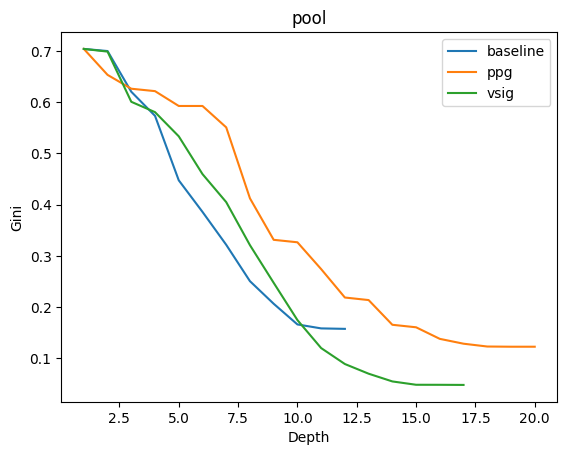

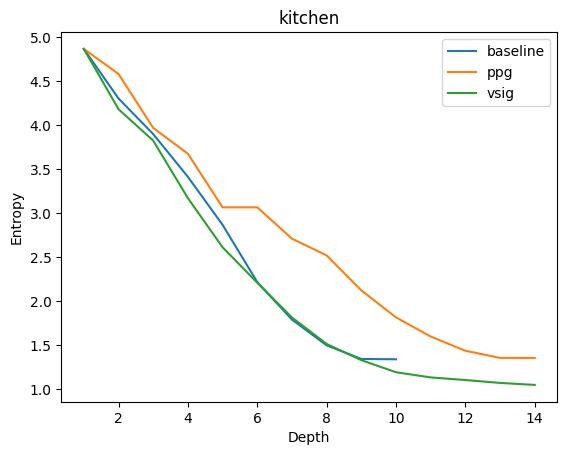

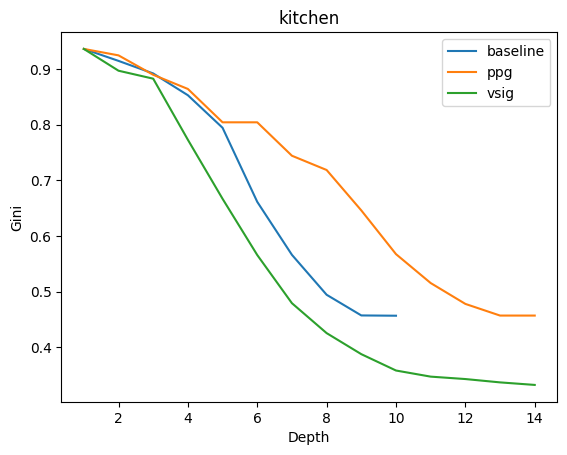

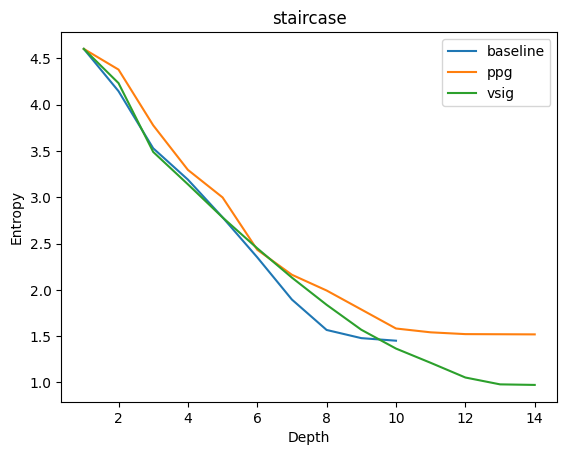

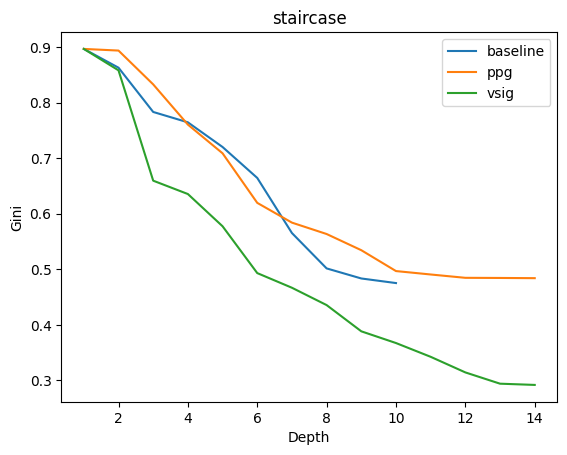

In [13]:
# End to end test

def plot_trees(scene, variant, metric, metric_name, methods, title):
    iteration = 1

    plt.figure()
    for method in methods:
        kdtree_path = f"{root_dir}/{scene}/{scene}{variant}-kdtree_{method}-dump.csv"
        sample_dir = f"{root_dir}/{scene}/{scene}{variant}-samples-{method}-dump"
        position_path = f"{sample_dir}/position-{iteration}.npy"
        shapeId_path = f"{sample_dir}/shapeId-{iteration}.npy"

        samples = np.load(position_path)
        ids = np.load(shapeId_path)
        _, ids = np.unique(ids, return_inverse=True)

        tree = load_tree(kdtree_path)
        depths, losses = compute_impurity_curve(tree, metric, samples, ids)
        plt.plot(depths, losses, label=method)
    
    plt.xlabel("Depth")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.legend()
    plt.show()


scene_variants = [
    ["torus", ["-glass", "-multi-complex"]],
    ["cbox-empty", [""]],
    ["cbox-classic", [""]],
    ["pbrt-book", [""]],
    ["classroom", ["-day", "-lightson"]],
    ["sanmiguel", ["-in-tree"]],
    ["pool", [""]],
    ["kitchen", [""]],
    ["staircase", [""]],
]

methods = ['baseline', 'ppg', 'vsig']

for scene, variants in scene_variants:
    for variant in variants:
        plot_trees(scene, variant, entropy, 'Entropy', methods, title=f"{scene}{variant}")
        plot_trees(scene, variant, gini, 'Gini', methods, title=f"{scene}{variant}")